# Generating adverserial attacks using GAMSPy

Neural networks operate as black-box learners, making it challenging to decipher the criteria behind their decision-making processes. Understanding these criteria is non-trivial, posing a significant hurdle in interpreting neural network decisions.

Consequently, validation becomes an indispensable phase in any project utilizing neural networks. It serves as a crucial step in ensuring the reliability and accuracy of these networks.

Moreover, the introduction of GAMSPy has notably simplified the utilization of GAMS for generating adversarial examples. This advancement enhances accessibility and ease of employing GAMS within various applications.


## Objectives:

1. **Neural Network Training:**
   - Employ PyTorch to train a compact neural network using the MNIST dataset for accurate digit recognition.

2. **Integration with GAMSPy:**
   - Transfer the learned weights from the trained neural network to GAMSPy.
   - Express the forward pass of the neural network within GAMSPy.

3. **Adversarial Example Formulation:**
   - Define the generation of adversarial examples as a non-linear optimization problem using GAMS.
   - Leverage GAMS to produce adversarial examples based on the formulated optimization problem.

4. **Validation and Showcase:**
   - Showcase the generated adversarial examples.
   - Implement a validation process to ensure the misclassification of the showcased examples.

## What is the required background?

Prior familiarity with PyTorch, feed-forward neural network training, and underlying mathematical concepts is recommended.


### Training the Feed-Forward Network

The objective is to train a straightforward feed-forward neural network capable of correctly identifying the digit represented by an input image.

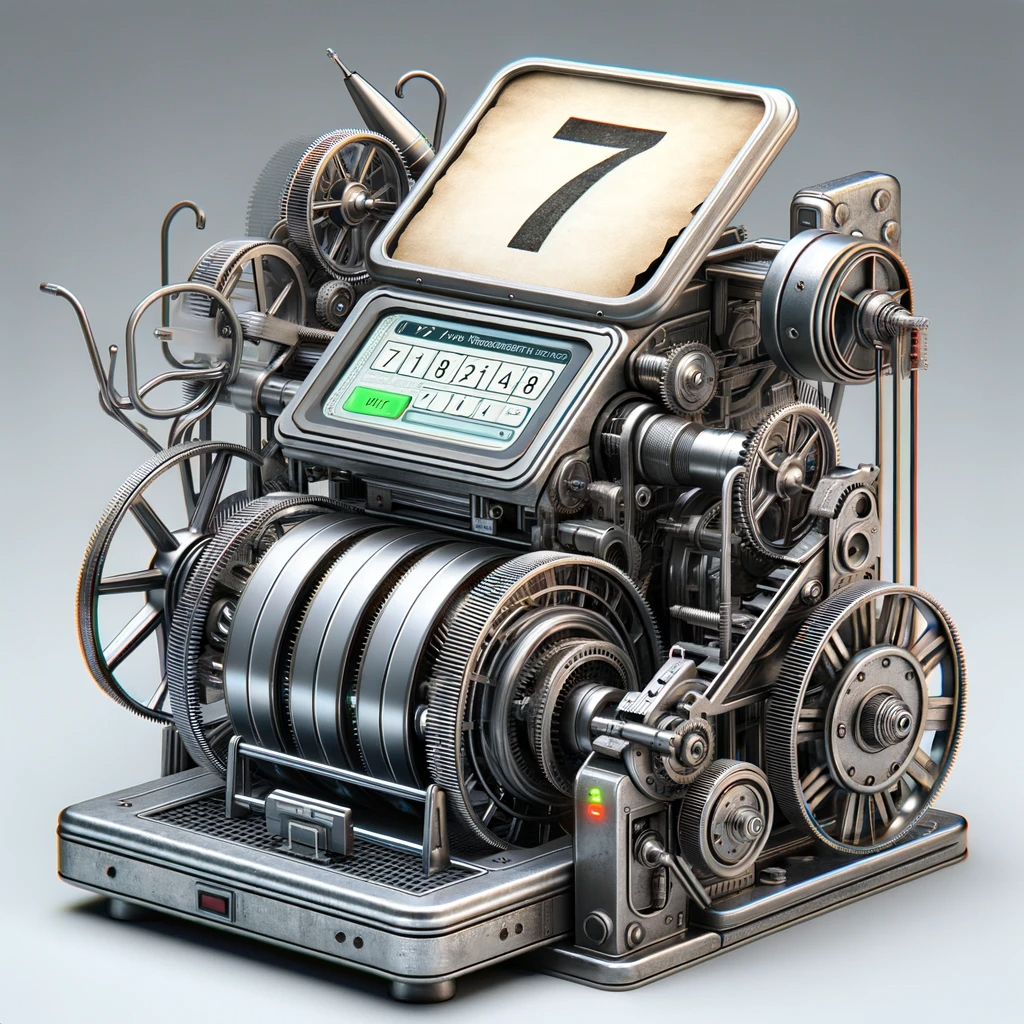


This neural network comprises three layers with the following neuron counts: 784 (input), 800 (hidden), and 10 (output). The input images are grayscale 28x28 images.

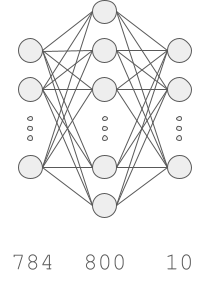

To achieve this, we've adapted a section of the classical MNIST example found in PyTorch tutorials. Notably, our model differs from a Convolutional Neural Network (CNN); instead, it's structured as a feed-forward network.

For reference, you can find the tutorial we've used as a basis at [this GitHub link](https://github.com/pytorch/examples/blob/main/mnist/main.py).

### Define imports

If you don't have the GAMSPy already

- `pip install gamspy`
- `gamspy install solver knitro`

If you need PyTorch, you can find the installation guide at https://pytorch.org/

Additionally, `pip install torchvision pandas`

In [1]:
import argparse
import sys
from typing import Tuple

import gamspy as gp
import gamspy.math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import pandas as pd

/Users/ngocanhdoan/MLM/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Let's define a very simple neural network

The feed-forward network comprises an input layer with 784 neurons, representing the 784 pixels of the input image, while the hidden layer contains 800 neurons.

The output layer consists of 10 neurons, each corresponding to one of the 10 possible digits

In [2]:
hidden_layer_neurons = 20

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, hidden_layer_neurons, bias=False)
        self.activation = nn.Tanh()
        self.l2 = nn.Linear(hidden_layer_neurons, 10, bias=False)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.l1(x)
        x = self.activation(x)
        logits = self.l2(x)
        output = F.log_softmax(logits, dim=1)
        return output

### Define training functions
As our primary focus is on generating adversarial examples rather than training the network, we utilize the code provided in the previously mentioned PyTorch tutorial.

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Train the neural network

Typically, networks undergo more extended training periods.

However, due to the relatively simplistic nature of the MNIST dataset, achieving commendable performance requires only a relatively short training duration.

In [4]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')

# you can play with different parameters
args = parser.parse_args([
    "--epochs=5",
    "--log-interval=100",
    "--test-batch-size=16" # number of adverserial examples
])

torch.manual_seed(args.seed)
device = torch.device("cpu") # or cuda if you like

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}


mean = (0.1307,)
std = (0.3081,)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])
transform2 = transforms.Compose([transforms.ToTensor()])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False, download=True,
                          transform=transform)
non_transformed_test = datasets.MNIST('../data', train=False,
                                      transform=transform2)

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
non_transformed_loader = torch.utils.data.DataLoader(non_transformed_test, **test_kwargs)
model = SimpleModel().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335711
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.390588
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.300583
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.373462
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.261049
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.372822
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.295970
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.383538
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.241864
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.358269

Test set: Average loss: 0.2532, Accuracy: 9246/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.164772
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.199850
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.188138
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.267577
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.195545
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.223507
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.224444
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.359290
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.187366
T

### Transferring the neural network to GAMSPy

Given our choice of a relatively compact neural network, the transition to GAMSPy necessitates supporting fewer operations.

Let $x_1 \in \mathbf{R}^{784}$ denote the input vector of a sample, with $w_1 \in \mathbf{R}^{784 \times 800}$ and $w_2 \in \mathbf{R}^{800 \times 10}$ representing the weights of the first and second linear layers, respectively.

The output of the first layer, $a_2$, is computed as $a_2 = \text{tanh}(w_1^T x_1)$, followed by the output of the second layer, $a_3 = \text{softmax}(w_2^T a_2)$.

In this context, the crucial operations for support are limited to matrix multiplication, tanh, and softmax. We opt to work with logits rather than softmax probabilities, as GAMS and GAMSPy already implement tanh, leaving only matrix multiplication for implementation in GAMSPy. To facilitate this, we've pre-implemented the matrix multiplication in `matrix.py`.

Embedding the neural network within the model allows for automatic updating of the output vector upon alterations to the input vector, as depicted below:

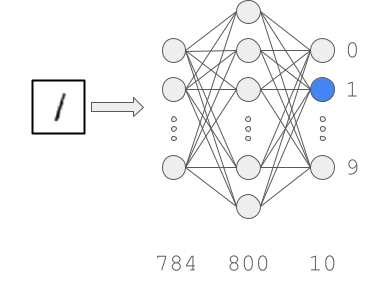

However, our objective is to introduce noise to the image, inducing a change in the predicted label, as illustrated here:

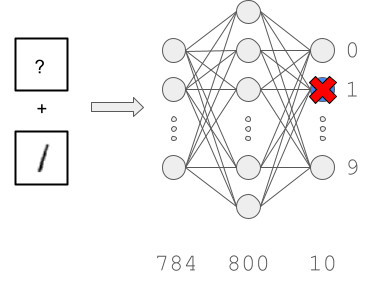

Formally, we aim to ensure that the logit value of the original label plus $\epsilon$(epsilon) is less than the other logit values, leading to a change in the predicted label upon noise addition.

The challenge lies in finding minimal noise—perturbation so subtle that it induces a label change without significantly altering the image. To accomplish this, we seek the smallest-norm noise vector that causes a change in the output classification.

In this instance, we've utilized the $l_2$ norm, although the implementation supports the $l_\infty$ norm as well.

Running the following code snippet might take a while depending on the hardware

In [5]:
from gamspy.math.matrix import dim

# Get a single batch of data
for data, target in non_transformed_loader:
    data, target = data.to(device), target.to(device)
    break

batch = args.test_batch_size

# reshape the input so it matches our declaration in GAMSPy
data = data.reshape(batch, -1).T

# reshape the target, labels, so that we can provide them to GAMSPy
target_df = pd.DataFrame(target.cpu())
target_df["val"] = 1
target_df = target_df.pivot(columns=[0], values="val").fillna(0).astype(bool)


# Create a container
m = gp.Container()

# Set epsilon as you wish, higher it is, harder to solve
diff_eps = 0.01

w1_data = model.l1.weight.cpu().detach().numpy().T
w2_data = model.l2.weight.cpu().detach().numpy().T
init_data = data.cpu().detach().numpy()

w1 = gp.Parameter(m, name="w1", domain=dim(w1_data.shape), records=w1_data)
w2 = gp.Parameter(m, name="w2", domain=dim(w2_data.shape), records=w2_data)
init = gp.Parameter(m, name="inp", domain=dim(init_data.shape), records=init_data)

# unify how dims are written in the way that 784 vs shapes

# x_n stands for noise vector
xn = gp.Variable(m, name="xn", domain=dim((784, batch)))
x1 = gp.Variable(m, name="x1", domain=dim((784, batch)))
x2 = gp.Variable(m, name="x2", domain=dim((hidden_layer_neurons, batch)))
x3 = gp.Variable(m, name="x3", domain=dim((10, batch)))
a2 = gp.Variable(m, name="a2", domain=dim((hidden_layer_neurons, batch)))
a3 = gp.Variable(m, name="a3", domain=dim((10, batch)))

sample_domain = xn.domain[1]
digits_domain = a3.domain[0]


target_set = gp.Set(m, name="targets", domain=[sample_domain, digits_domain], records=target_df, uels_on_axes=True)

# Assume we will get non-normalized input
# This step is important because when we trained our neural network we normalized
# with a mean and standard deviation, and here we need to do the same
normalize_input = gp.Equation(m, name="transform_input", domain=x1.domain)

# Input to the neural network is noise + input image normalized
normalize_input[...] = x1[...] == (xn[...] + init[...] - mean[0]) / std[0]

# Noise has some limits since neural network was trained with the assumption
# that the values are between 0-1 for the input
xn.lo[...] = - init[...]
xn.up[...] = - init[...] + 1 

calc_mm_1 = gp.Equation(m, name="calc_mm_1", domain=[w1.domain[1], x1.domain[1]])
calc_mm_1[...] = a2 == w1.t() @ x1

calc_activation = gp.Equation(m, name="calc_activation", domain=x2.domain)
calc_activation[...] = x2[...] == gp.math.tanh(a2[...])

calc_mm_2 = gp.Equation(m, name="calc_mm_2", domain=[w2.domain[1], x2.domain[1]])
calc_mm_2[...] = a3 == w2.t() @ x2 

obj = gp.Variable(m, name="obj", domain=[sample_domain])
eq_so_far = m.getEquations()

results = []
result_z = []
result_a = []

# For every sample we need to solve another optimization problem
# to find the minimal vector that changes the label
for s in range(batch):
    sample_target = int(target[s])
    print("sample", f"{s + 1}/{batch}")

    # Ensure the correct label gets less probability than the incorrect labels
    make_noise = gp.Equation(m, name=f"false_label_{s}", domain=[digits_domain])
    make_noise[digits_domain].where[gp.Ord(digits_domain) != sample_target + 1] = a3[digits_domain, str(s)]  >= a3[str(sample_target), str(s)] + diff_eps
    
    z = gp.Variable(m, name="z")
    specific_equations = [make_noise]

    # pick which norm you would like to use
    norm = "l2"
    if norm == "l2":
        noise_magnitude = gp.Equation(m, name=f"noise_magnitude_{s}")
        noise_magnitude[...] = z == gp.math.vector_norm(xn[:, str(s)]) ** 2  # TODO gp.math.vector_norm(xn)
        specific_equations.append(noise_magnitude)
    elif norm == "linf":
        noise_magnitude_1 = gp.Equation(m, name=f"noise_magnitude_1_{s}", domain=xn.domain)
        noise_magnitude_2 = gp.Equation(m, name=f"noise_magnitude_2_{s}", domain=xn.domain)
        noise_magnitude_1[xn.domain[0], str(s)] = z >=  xn[xn.domain[0], str(s)]
        noise_magnitude_2[xn.domain[0], str(s)] = z >= -xn[xn.domain[0], str(s)]
        specific_equations.append(noise_magnitude_1)
        specific_equations.append(noise_magnitude_2)
    
    
    model_noise = gp.Model(
        m,
        name="noise",
        equations=[*eq_so_far, *specific_equations],
        problem="NLP",
        sense="min",
        objective=z,
    )

    # Knitro is a local MINLP solver, so we will get a local optima
    model_noise.solve(solver='CONOPT3') # output=sys.stdout if you like to show the log from the solver
    res = xn.records.copy()

    noise = np.array(res[res[f"DenseDim{batch}_1"] == str(s)].level).reshape(28, 28)
    # copy newly predicted output by GAMS
    output = a3.records.copy()
    
    output = np.array(output[output[f"DenseDim{batch}_1"] == str(s)].level)
    result_a.append(output)
    # store the noise
    results.append(noise)
    # store the norm of the noise
    result_z.append(z.records.copy().level[0])

sample 1/16
sample 2/16
sample 3/16
sample 4/16
sample 5/16
sample 6/16
sample 7/16
sample 8/16
sample 9/16
sample 10/16
sample 11/16
sample 12/16
sample 13/16
sample 14/16
sample 15/16
sample 16/16


## Pick the example where perturbation was minimal

In [6]:
result_rankings = [(x, i) for i, x in enumerate(result_z)]
result_rankings = [x for x in sorted(result_rankings)]
result_rankings

[(np.float64(1.1407272193532416), 11),
 (np.float64(1.5751693316915067), 2),
 (np.float64(2.397332351285267), 5),
 (np.float64(2.597191841920587), 15),
 (np.float64(2.7134359839327393), 8),
 (np.float64(2.9933095279463426), 12),
 (np.float64(3.0291646094390026), 4),
 (np.float64(3.381039755914477), 6),
 (np.float64(3.6187754248958393), 7),
 (np.float64(4.054562901814966), 14),
 (np.float64(4.382233726318273), 0),
 (np.float64(4.614623453067556), 10),
 (np.float64(5.7413240287971945), 9),
 (np.float64(8.546719528421418), 1),
 (np.float64(8.992527458490141), 3),
 (np.float64(14.868353743551147), 13)]

/var/folders/26/ppqp0ttx0v52x7b_d4jb1ylr0000gn/T/ipykernel_23864/753105165.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  noisy_image = sample.cpu() + noise


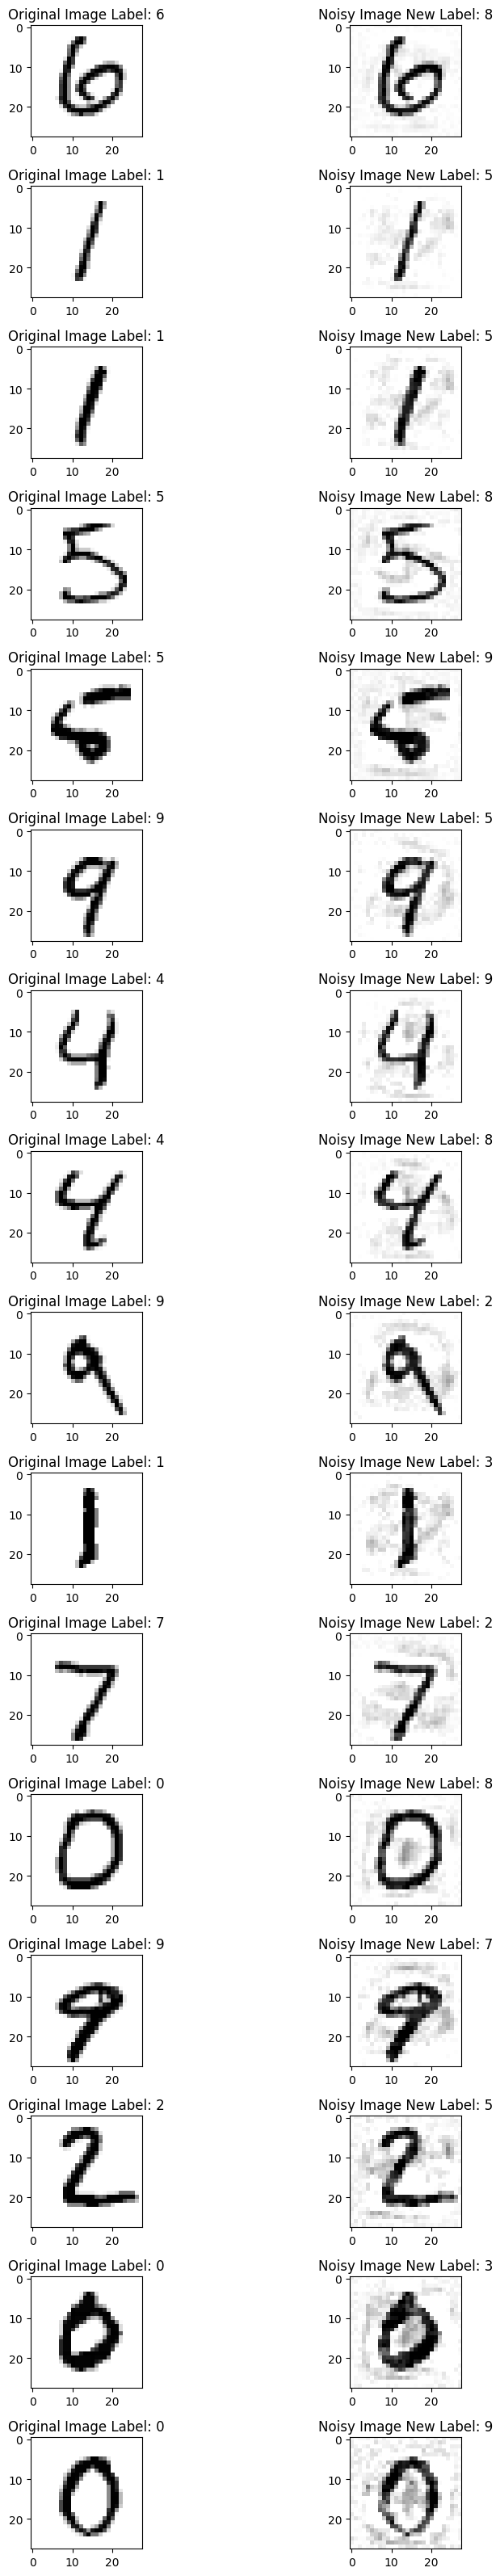

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

show_n_samples = 16
sample_indices = [x[1] for x in result_rankings[:show_n_samples]] 


plt.figure(figsize=(10, show_n_samples * 2))

for row, compare_index in enumerate(sample_indices):
    sample = data[:, compare_index].reshape(28, 28)
    noise = np.array(results[compare_index])
    noisy_image = sample.cpu() + noise

    true_label = int(target[compare_index])
    gams_new_label = np.argmax(result_a[compare_index])
    
    # pass noisy image and original image to model to see what it classifies
    with torch.no_grad():
        normalized = transform(np.array(noisy_image)).float().to(device)
        old_normalized = transform(np.array(sample.cpu())).float().to(device)
        pred_new = int(torch.argmax(model(normalized)))
        pred_old = int(torch.argmax(model(old_normalized.to(device))))
        assert pred_new != pred_old, "NN prediction did not change"
        assert pred_new == gams_new_label, "GAMS label and NN label did not match"
        
    plt.subplot(show_n_samples, 2, 2 * row + 1)
    plt.imshow(sample.cpu().squeeze(0), cmap='binary', vmin=0, vmax=1)
    plt.title(f'Original Image Label: {true_label}')
    
    plt.subplot(show_n_samples, 2, 2 * row + 2)
    plt.imshow(noisy_image.cpu().squeeze(0), cmap='binary', vmin=0, vmax=1)
    plt.title(f'Noisy Image New Label: {gams_new_label}')
    
plt.tight_layout()
plt.show()

### Conclusion

While we demonstrated using a simple network for illustration, the potential extends far beyond. It's conceivable to adapt these formulations to accommodate more intricate architectures such as Convolutional Neural Networks (CNNs), Long Short-Term Memory networks (LSTMs), or even potentially Transformers. This flexibility underscores the versatility of GAMSPy in collaboration with various neural network structures.

### Reference

- For PyTorch, https://pytorch.org/
- MNIST dataset from https://yann.lecun.com/exdb/mnist/
- Literature on adversarial attacks is vast, but for a further read we found `Threat of Adversarial Attacks on Deep Learning
in Computer Vision: A Survey` by Akhtar and Mian useful.
